In [32]:
import os 
import random 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss,L1Loss

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

In [2]:
from src.datasets.data import PAMAP2Reader
# from src.datasets.dataset import PAMAP2Dataset

from src.models.ts_transformer import RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 
from src.utils.losses import SupConLoss

from src.utils.analysis import action_evaluator

In [3]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2", # "PAMAP2", "DaLiAc", "UTD"
    "Model": "RelativeGlobalAttention",
    "sem-space": 'attr',
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "lr": 0.001,
    "ae_lr": 0.0001,
    "imu_lr": 0.0004,
    "ae_alpha": 0.7,
    "imu_alpha": 0.3,
    "n_epochs": 6,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    "feat_size": 64, # skel-AE hidden size and IMU-Anc output size
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 50,  # skeleton seq. length
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---

In [4]:
class Model6a(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, n_classes, max_len=1024, dropout=0.1):
        super(Model6a, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 
        self.n_classes = n_classes

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu  # _get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)
        self.logist = nn.Linear(self.ft_size, self.n_classes)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out1 = self.DenseL2(out)   
        out = self.logist(out1)     
        return out, out1

---

In [5]:

class BiLSTMEncoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size,linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32):
        super(BiLSTMEncoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len

        # define LSTM layer
        self.layers = []

        # add linear layers 
        for __id,layer_out in enumerate(self.linear_filters):
            if __id == 0:
                self.layers.append(nn.Linear(self.input_size, layer_out))
            else:
                self.layers.append(nn.Linear(self.linear_filters[__id-1], layer_out))

        # add lstm layer
        self.lstm = nn.LSTM(input_size = layer_out, hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=self.bidirectional,
                            batch_first=True)
        
        self.net = nn.Sequential(*self.layers)

        #add embedding out
        if bidirectional:
            self.out_linear = nn.Linear(self.hidden_size*4, self.embedding_size)
        else:
            self.out_linear = nn.Linear(self.hidden_size*2, self.embedding_size)

        
    def forward(self, x_input):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        x = self.net(x_input)
        lstm_out, self.hidden = self.lstm(x)
        hidden_transformed = torch.concat(self.hidden,0)
        hidden_transformed = torch.transpose(hidden_transformed,0,1)
        hidden_transformed = torch.flatten(hidden_transformed,start_dim=1)
        
        hidden_transformed = self.out_linear(hidden_transformed)
        
        return lstm_out, hidden_transformed

    
class BiLSTMDecoder(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters,embedding_size:int, num_layers = 1,bidirectional=True,batch_size=32, device='cpu'):
        super(BiLSTMDecoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        self.device = device

        if bidirectional:
            self.input_linear = nn.Linear(self.embedding_size,4*self.hidden_size)
        else:
            self.input_linear = nn.Linear(self.embedding_size,2*self.hidden_size)

        # define LSTM layer
        self.layers = []
        # add lstm
        self.lstm = nn.LSTM(input_size = self.linear_filters[0], hidden_size = self.hidden_size,
                            num_layers = self.num_layers, bidirectional=True,
                            batch_first=bidirectional)

                        
        # add linear layers 
        if bidirectional:
            self.layers.append(nn.Linear(2*hidden_size,self.linear_filters[0]))
        else:
            self.layers.append(nn.Linear(hidden_size,self.linear_filters[0]))

        for __id,layer_in in enumerate(self.linear_filters):
            if __id == len(linear_filters)-1:
                self.layers.append(nn.Linear(layer_in,self.input_size))
            else:
                self.layers.append(nn.Linear(layer_in,self.linear_filters[__id+1]))

        self.net = nn.Sequential(*self.layers)

        
        

    def forward(self,encoder_hidden):
        '''
        : param x_input:               input of shape (seq_len, # in batch, input_size)
        : return lstm_out, hidden:     lstm_out gives all the hidden states in the sequence; hidden gives the hidden state and cell state for the last element in the sequence                         
        '''
        
        
        hidden_shape = encoder_hidden.shape
        encoder_hidden = self.input_linear(encoder_hidden)
        
        if self.bidirectional:
            hidden = encoder_hidden.view((self.batch_size,4,self.hidden_size))
            # print(hidden.shape)
            hidden = torch.transpose(hidden,1,0)
            h1,h2,c1,c2 = torch.unbind(hidden,0)
            h,c = torch.stack((h1,h2)),torch.stack((c1,c2))
        else:
            hidden = encoder_hidden.view((self.batch_size,2,self.hidden_size))
            hidden = torch.transpose(hidden,1,0)
            h,c = torch.unbind(hidden,0)
        
        dummy_input = torch.rand((self.batch_size,self.seq_len,self.hidden_size), requires_grad=True)
        dummy_input = dummy_input.to(self.device)
        
        lstm_out, self.hidden = self.lstm(dummy_input,(h,c))
        x = self.net(lstm_out)
        
        return x

class BiLSTMEncDecModel(nn.Module):
    def __init__(self,seq_len, input_size, hidden_size, linear_filters=[128,256,512],embedding_size:int=256, num_layers = 1,bidirectional=True, batch_size=32, device='cpu'):
        super(BiLSTMEncDecModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.linear_filters = linear_filters[::-1]
        self.embedding_size = embedding_size
        self.bidirectional = bidirectional
        self.batch_size = batch_size
        self.seq_len = seq_len
        
        self.encoder = BiLSTMEncoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32)
        self.decoder = BiLSTMDecoder(seq_len, input_size, hidden_size, linear_filters,embedding_size, num_layers = 1,bidirectional=True,batch_size=32, device=device)
        
    def forward(self,x):
        lstm_out,embedding = self.encoder(x)
        decoder_out = self.decoder(embedding)
        
        return decoder_out, embedding  
        

In [6]:
ae_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers=1,bidirectional=True,batch_size=32)
prep_dir = './tmp/random_input_100_epochs.pt'

ae_model.load_state_dict(torch.load(prep_dir))

<All keys matched successfully>

---

In [7]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# import PAMAP2 dataset
dt = config['dataset']
if dt == 'PAMAP2':
    dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')

actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\Pose-AE\src\datasets\data.py:62: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [9]:
if dt == 'PAMAP2':
    fold_classes = [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']]

fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

In [10]:
skeleton_data = np.load('./data/skeleton_movements.npz')
skeleton_classes, skeleton_mov = skeleton_data['arr_0'], skeleton_data['arr_1']

In [11]:
dataReader.label_map

[(1, 'lying'),
 (2, 'sitting'),
 (3, 'standing'),
 (4, 'walking'),
 (5, 'running'),
 (6, 'cycling'),
 (7, 'Nordic walking'),
 (9, 'watching TV'),
 (10, 'computer work'),
 (11, 'car driving'),
 (12, 'ascending stairs'),
 (13, 'descending stairs'),
 (16, 'vacuum cleaning'),
 (17, 'ironing'),
 (18, 'folding laundry'),
 (19, 'house cleaning'),
 (20, 'playing soccer'),
 (24, 'rope jumping')]

In [12]:
np.unique(skeleton_classes)

array(['Nordic walking', 'ascending stairs', 'car driving',
       'computer work', 'cycling', 'descending stairs', 'folding laundry',
       'house cleaning', 'ironing', 'lying', 'playing soccer',
       'rope jumping', 'running', 'sitting', 'standing',
       'vacuum cleaning', 'walking', 'watching TV'], dtype='<U17')

In [13]:
from collections import defaultdict

label2Id = {c[1]:i for i,c in enumerate(dataReader.label_map)}
action_dict = defaultdict(list)
skeleton_Ids = []
for i, a in enumerate(skeleton_classes):
    action_dict[label2Id[a]].append(i)
    skeleton_Ids.append(label2Id[a])

In [14]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5],
             9: [6, 7, 8, 9],
             8: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             5: [20, 21, 22, 23, 24],
             11: [25, 26, 27, 28, 29, 30],
             14: [31, 32, 33, 34, 35, 36, 37],
             15: [38, 39, 40, 41, 42, 43, 44],
             13: [45, 46, 47, 48, 49, 50],
             0: [51, 52],
             6: [53, 54, 55, 56, 57, 58, 59],
             16: [60, 61, 62, 63, 64],
             17: [65, 66],
             4: [67, 68, 69, 70, 71],
             1: [72, 73, 74, 75, 76, 77],
             2: [78, 79, 80, 81, 82],
             12: [83, 84, 85, 86, 87, 88],
             3: [89, 90, 91, 92],
             7: [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]})

---

In [15]:
class PAMAP2Dataset(Dataset):
    def __init__(self, data, actions, attributes, attribute_dict, action_classes, seq_len=120):
        super(PAMAP2Dataset, self).__init__()
        self.data = torch.from_numpy(data)
        self.actions = actions
        self.attribute_dict = attribute_dict
        self.seq_len = seq_len
        self.attributes = torch.from_numpy(attributes)
        self.action_classes = action_classes
        # build action to id mapping dict
        self.n_action = len(self.actions)
        self.action2Id = dict(zip(action_classes, range(self.n_action)))

    def __getitem__(self, ind):
        x = self.data[ind, ...]
        x_mask = np.array([0]) #self.padding_mask[ind, ...]
        target = self.actions[ind]
        y = torch.from_numpy(np.array([self.action2Id[target]]))
        # extraction semantic space generation skeleton sequences 
        skel_idx = random.choice(self.attribute_dict[target])
        y_feat = self.attributes[skel_idx, ...]
        return x, y, y_feat, x_mask

    def __len__(self):
        return self.data.shape[0]

    def getClassAttrs(self):
        sampling_idx = [random.choice(self.attribute_dict[i]) for i in self.action_classes]
        ft_mat = self.attributes[sampling_idx, ...]
        return ft_mat 

In [16]:
data_dict = dataReader.generate(unseen_classes=fold_cls_ids[0], seen_ratio=0.2, unseen_ratio=0.8, window_size=5.21, window_overlap=4.21, resample_freq=20)
sample_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=data_dict['seen_classes'], seq_len=100)
sample_dl = DataLoader(sample_dt, batch_size=32, shuffle=True, pin_memory=True, drop_last=True)
for d in sample_dl:
    print(d[0].shape)
    break

torch.Size([32, 105, 27])


In [17]:
r = sample_dt.getClassAttrs()
r.shape

torch.Size([14, 60, 36])

In [18]:
pr = F.pad(input=r, pad=(0, 0, 0, 0, 0, 18), mode='constant', value=0)
pr.shape

torch.Size([32, 60, 36])

In [19]:
torch.transpose(r[1, ...], 1, 0).shape

torch.Size([36, 60])

In [20]:
# r_out1, r_out2 = ae_model(torch.transpose(pr, 1, 0).float())
# r_out1.shape, r_out2.shape

---

In [21]:
class SkeletonDataset(Dataset):
    def __init__(self, movements, actions, action_dict, seq_len=60):
        super(SkeletonDataset, self).__init__()
        self.movements = movements[:, :seq_len, ...]
        self.actions = actions
        self.action_dict = deepcopy(dict(action_dict))
        self.actionsIDs = list(self.action_dict.keys())
        

    def __getitem__(self, idx):
        x1 = self.movements[idx, ...]
        action = self.actions[idx]

        partial_idx = random.sample(self.action_dict[action], k=1)[0]
        x2 = self.movements[partial_idx, ...]

        label = self.actionsIDs.index(action)
        # return np.transpose(x1, (1,0,2)), np.transpose(x2, (1,0,2)), label
        return x1, x2, label

    def __len__(self):
        return self.movements.shape[0]

    def getShape(self):
        return self.movements[0, ...].shape


In [22]:
action_dict

defaultdict(list,
            {10: [0, 1, 2, 3, 4, 5],
             9: [6, 7, 8, 9],
             8: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
             5: [20, 21, 22, 23, 24],
             11: [25, 26, 27, 28, 29, 30],
             14: [31, 32, 33, 34, 35, 36, 37],
             15: [38, 39, 40, 41, 42, 43, 44],
             13: [45, 46, 47, 48, 49, 50],
             0: [51, 52],
             6: [53, 54, 55, 56, 57, 58, 59],
             16: [60, 61, 62, 63, 64],
             17: [65, 66],
             4: [67, 68, 69, 70, 71],
             1: [72, 73, 74, 75, 76, 77],
             2: [78, 79, 80, 81, 82],
             12: [83, 84, 85, 86, 87, 88],
             3: [89, 90, 91, 92],
             7: [93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]})

In [23]:
sample_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=50)
sample_dl = DataLoader(sample_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
for b in sample_dl:
    bx1, bx2, by = b 
    # bx = torch.transpose(bx1, 1, 0)
    bs, seq_len, ft_in = bx1.shape
    print(bx1.shape)
    break 

torch.Size([32, 50, 36])


In [24]:
sample_dt.getShape()

(50, 36)

---

In [25]:
def imu_train_step1(model , ae, dataloader, optimizer, loss_module, device, class_names, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    ae = ae.eval()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, padding_masks = batch
            # print(X, targets, target_feat, target_attr)
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore

            # Zero gradients, perform a backward pass, and update the weights.
            optimizer.zero_grad()
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)
            
            with torch.set_grad_enabled(False):
                _, target_feat = ae(target_feat) # batch first mode

            class_loss = loss_module['class'](class_output, targets.squeeze())
            feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            if phase == 'train':
                loss.backward()
                optimizer.step()

            metrics = {"loss": loss.item()}
            with torch.no_grad():
                total_samples += len(targets)
                epoch_loss += loss.item()  # add total loss of batch

            # convert feature vector into action class
            # using cosine 
            pred_class = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            metrics["accuracy"] = accuracy_score(y_true=targets.cpu().detach().numpy(), y_pred=pred_class)
            tepoch.set_postfix(metrics)
            
    epoch_loss = epoch_loss / total_samples  # average loss per sample for whole epoch
    return metrics

In [26]:
def ae_train_step1(model , dataloader, optimizer, loss_module, device, batch_size, phase='train', l2_reg=False, loss_alpha=0.7):
    model = model.train()
    model.to(device)

    epoch_loss = 0 
    total_samples = 0 

    with tqdm(dataloader, unit='batch', desc=phase) as tepoch:
        for batch in tepoch:
            x1, x2, labels = batch 
            # post-process 
            xa = torch.vstack([x1, x2])  # batch first mode
            # device offload 
            xa = xa.float().to(device)
            labels = labels.float()

            # set optimizer grad to zero 
            optimizer.zero_grad()
            # get model prediction 
            with torch.set_grad_enabled(phase=='train'):
                skel_output, ft_output = model(xa)

            # reconstruct the output 
            f1, f2 = torch.split(ft_output, [batch_size//2, batch_size//2], dim=0)
            cons_output = torch.stack([f1.squeeze(1), f2.squeeze(1)], dim=1)
            # calc. contrastive loss 
            con_loss = loss_module['contrast'](cons_output, labels)
            # calc. reconstruction loss 
            l2_loss = loss_module['recons'](xa, skel_output)
            # calc. total loss
            total_loss = loss_alpha*con_loss + (1-loss_alpha)*l2_loss

            if phase == 'train':
                total_loss.backward()
                optimizer.step()

            metrics = {'contrastive loss ': con_loss.item(), 'reconstruction loss': l2_loss.item()}
            with torch.no_grad():
                    total_samples += len(labels)
                    epoch_loss += total_loss.item()
            
            tepoch.set_postfix(metrics)

    epoch_loss = epoch_loss/total_samples
    return metrics

In [30]:
def eval_step1(model, ae, dataloader, loss_module, device, class_names, target_feat_met, phase='seen', l2_reg=False, print_report=True, show_plot=True, loss_alpha=0.7, batch_size=32):
    model = model.train()
    ae = ae.eval()

    epoch_loss = 0  # total loss of epoch
    total_samples = 0  # total samples in epoch
    per_batch = {'target_masks': [], 'targets': [], 'predictions': [], 'metrics': [], 'IDs': []}

    # generate unseen action_semantic from unseen skeleton seq. 
    ns, _, _ = target_feat_met.shape 
    padded_mat = F.pad(input=target_feat_met, pad=(0,0,0,0,0,batch_size-ns), mode='constant', value=0)
    _, vector_out = ae(padded_mat.float().to(device)) # batch second mode
    action_feat_mat = vector_out[:ns, :].cpu().detach().numpy() # batch second mode

    # print("target feat mat", target_feat_met.shap e, "action feat mat", action_feat_mat.shape)

    with tqdm(dataloader, unit="batch", desc=phase) as tepoch:
        for batch in tepoch:
            X, targets, target_feat, padding_masks = batch
            X = X.float().to(device)
            target_feat = target_feat.float().to(device)
            targets = targets.long().to(device)
            padding_masks = padding_masks.to(device)  # 0s: ignore
            # forward
            # track history if only in train
            with torch.set_grad_enabled(phase == 'train'):
            # with autocast():
                class_output, feat_output = model(X)

            with torch.set_grad_enabled(False):
                _, target_feat = ae(target_feat) # batch second mode
                
            class_loss = loss_module['class'](class_output, targets.squeeze())
            feat_loss = loss_module['feature'](feat_output, target_feat)

            loss = loss_alpha*class_loss+(1-loss_alpha)*feat_loss

            # convert feature vector into action class
            # using cosine 
            if phase == 'seen':
                pred_action = np.argmax(class_output.cpu().detach().numpy(), axis=1)
            else:
                # print("feat output", feat_output.shape)
                feat_numpy = feat_output.cpu().detach().numpy()
                action_probs = euclidean_distances(feat_numpy, action_feat_mat)
                pred_action = np.argmin(action_probs, axis=1)
                
            per_batch['targets'].append(targets.cpu().numpy())
            per_batch['predictions'].append(pred_action)
            per_batch['metrics'].append([loss.cpu().numpy()])

            tepoch.set_postfix({"loss": loss.item()})
    
    all_preds = np.concatenate(per_batch["predictions"])
    all_targets = np.concatenate(per_batch["targets"])
    metrics_dict = action_evaluator(y_pred=all_preds, y_true=all_targets[:, 0], class_names=class_names, print_report=print_report, show_plot=show_plot)
    return metrics_dict

---

================ Fold-0 ================
Initiate IMU datasets ...
Initiate Skeleton dataset ... 
Initial Models ...
Start Models training ...


seen: 100%|██████████| 130/130 [00:12<00:00, 10.30batch/s, loss=0.523]


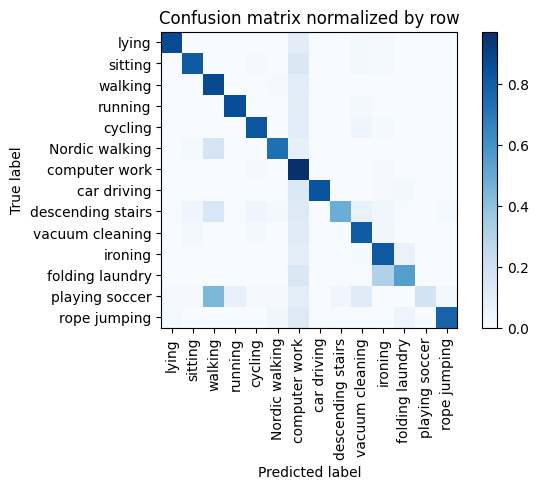

Training Epoch:  17%|█▋        | 1/6 [01:14<06:10, 74.07s/it]

Overall accuracy: 0.800



seen: 100%|██████████| 130/130 [00:13<00:00,  9.48batch/s, loss=0.364]


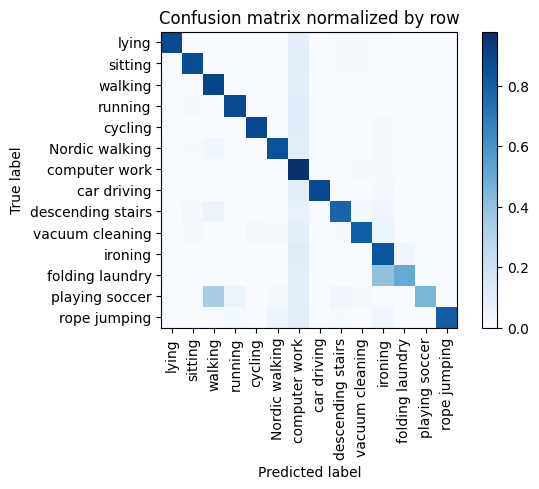

Training Epoch:  33%|███▎      | 2/6 [02:26<04:53, 73.34s/it]

Overall accuracy: 0.848



seen: 100%|██████████| 130/130 [00:12<00:00, 10.20batch/s, loss=0.308]


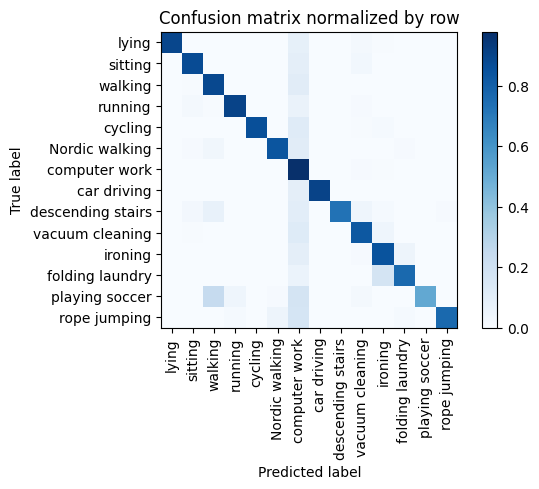

Training Epoch:  50%|█████     | 3/6 [03:45<03:47, 75.69s/it]

Overall accuracy: 0.860



seen: 100%|██████████| 130/130 [00:11<00:00, 11.16batch/s, loss=0.283]


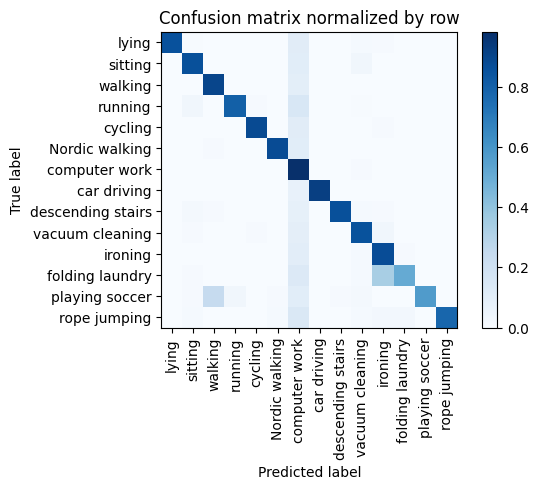

Training Epoch:  67%|██████▋   | 4/6 [04:53<02:25, 72.52s/it]

Overall accuracy: 0.858



seen: 100%|██████████| 130/130 [00:16<00:00,  7.84batch/s, loss=0.235]


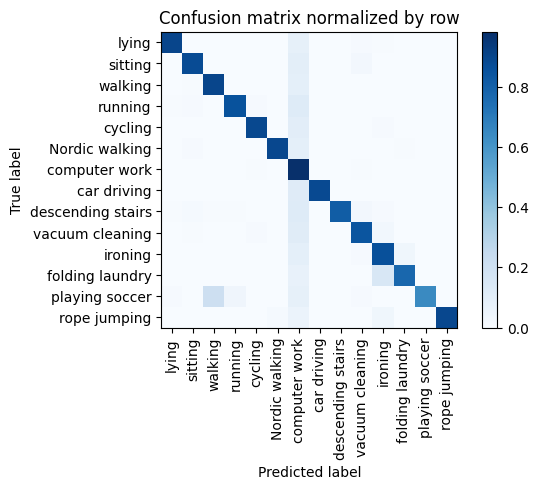

Training Epoch:  83%|████████▎ | 5/6 [06:11<01:14, 74.76s/it]

Overall accuracy: 0.881



seen: 100%|██████████| 130/130 [00:13<00:00,  9.61batch/s, loss=0.193]


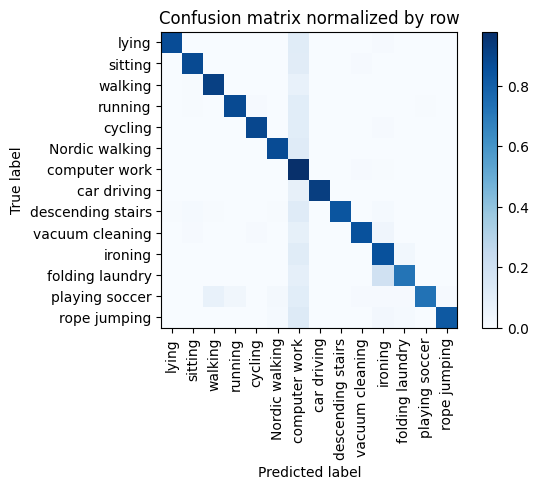

Overall accuracy: 0.878



unseen: 100%|██████████| 175/175 [00:15<00:00, 11.49batch/s, loss=3]   


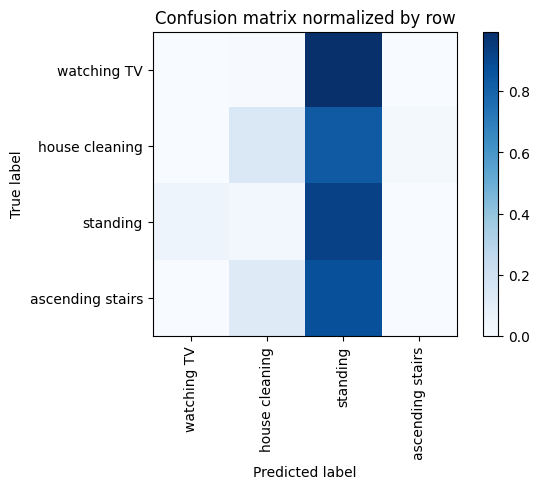

Overall accuracy: 0.354

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.342      0.925      0.499      0.331       1851|	 watching TV: 0.049,	house cleaning: 0.025,	
  house cleaning       0.591      0.145      0.232      0.328       1839|	 standing: 0.834,	ascending stairs: 0.021,	
ascending stairs       0.091      0.004      0.007      0.193       1079|	 standing: 0.872,	house cleaning: 0.123,	
     watching TV       0.000      0.000      0.000      0.148        831|	 standing: 0.994,	house cleaning: 0.006,	ascending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.325      0.354      0.243        1.0       5600|	      

{'total_accuracy': 0.35410714285714284, 'precision': 0.25591590012611154, 'recall': 0.2684491673572626, 'f1': 0.18464821149661523}
================ Fold-1 ================
Initiate IMU datasets ...
Initiat

seen: 100%|██████████| 131/131 [00:13<00:00,  9.91batch/s, loss=0.489]


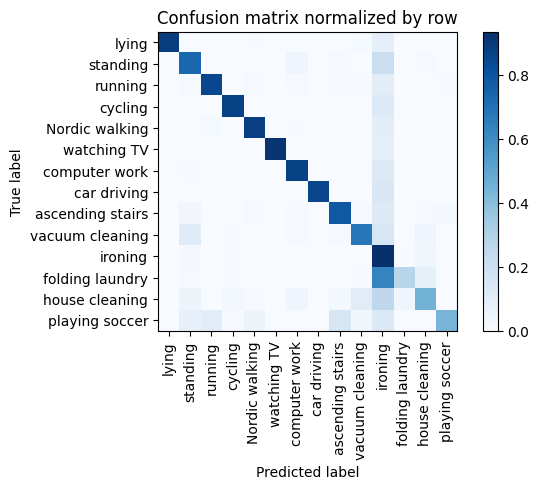

Training Epoch:  17%|█▋        | 1/6 [01:10<05:51, 70.29s/it]

Overall accuracy: 0.772



seen: 100%|██████████| 131/131 [00:16<00:00,  8.10batch/s, loss=0.344]


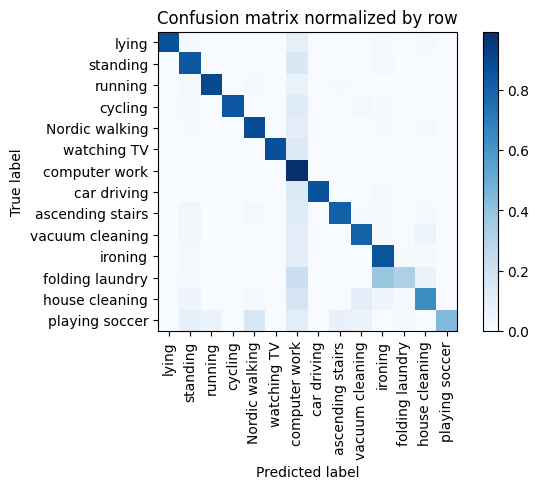

Training Epoch:  33%|███▎      | 2/6 [02:27<04:56, 74.15s/it]

Overall accuracy: 0.818



seen: 100%|██████████| 131/131 [00:15<00:00,  8.28batch/s, loss=0.333]


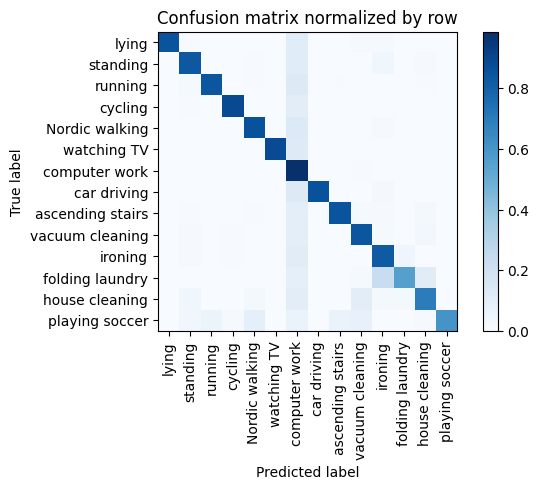

Training Epoch:  50%|█████     | 3/6 [03:57<04:04, 81.35s/it]

Overall accuracy: 0.837



seen: 100%|██████████| 131/131 [00:11<00:00, 11.54batch/s, loss=0.375]


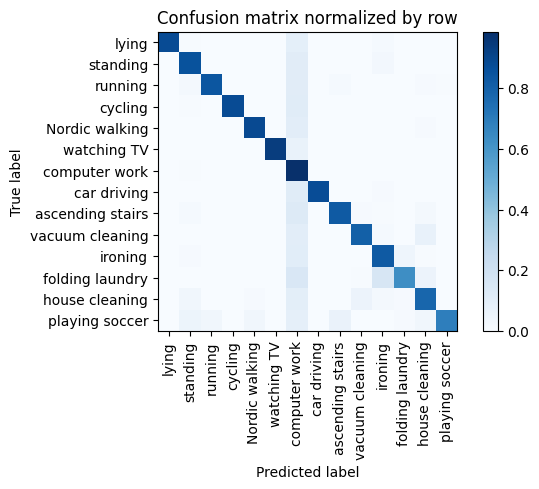

Training Epoch:  67%|██████▋   | 4/6 [05:12<02:38, 79.19s/it]

Overall accuracy: 0.854



seen: 100%|██████████| 131/131 [00:11<00:00, 11.53batch/s, loss=0.273]


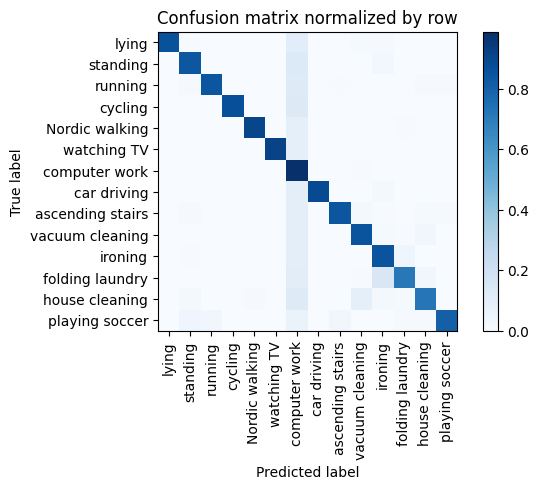

Training Epoch:  83%|████████▎ | 5/6 [06:20<01:14, 74.91s/it]

Overall accuracy: 0.860



seen: 100%|██████████| 131/131 [00:16<00:00,  8.02batch/s, loss=0.247]


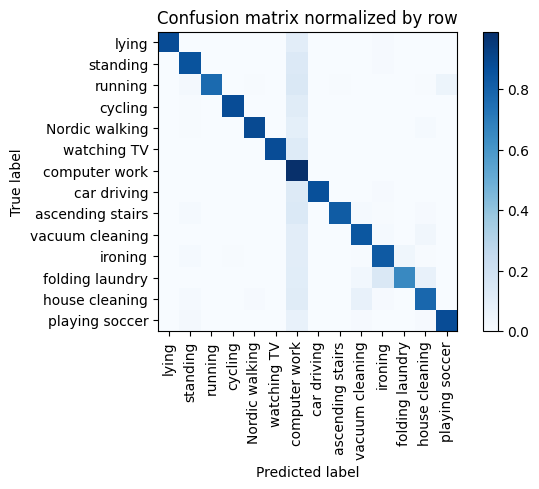

Overall accuracy: 0.857



unseen: 100%|██████████| 173/173 [00:16<00:00, 10.22batch/s, loss=3.51]


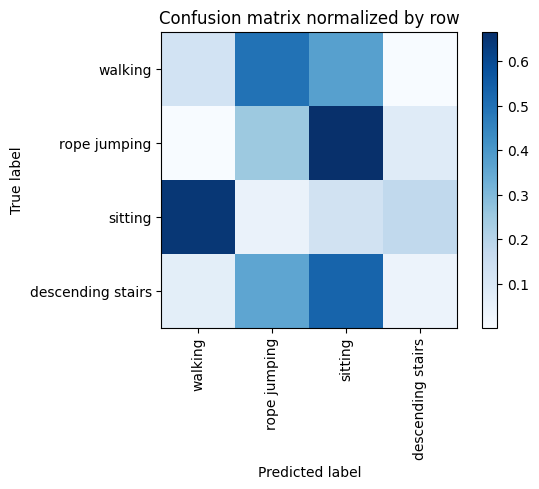

Overall accuracy: 0.123

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.194      0.127      0.153      0.421       2332|	 rope jumping: 0.497,	sitting: 0.374,	
          sitting       0.122      0.130      0.126      0.324       1794|	 walking: 0.648,	descending stairs: 0.178,	
descending stairs       0.092      0.039      0.055      0.171        949|	 sitting: 0.532,	rope jumping: 0.359,	walking: 0.070,	
     rope jumping       0.068      0.252      0.108      0.083        461|	 sitting: 0.666,	descending stairs: 0.080,	

----------------------------------------------------------------------------------------------------
      avg / total       0.142      0.123      0.124        1.0       5536|	      

{'total_accuracy': 0.12301300578034682, 'precision': 0.11901255281685597, 'recall': 0.13674838338497045, 'f1': 0.11026076205139537}
================ Fold-2 ================
Initiate IMU datasets ...
Initiate Skeleto

seen:  50%|█████     | 61/121 [00:08<00:08,  7.25batch/s, loss=0.535]


KeyboardInterrupt: 

In [33]:
prep_dir = './tmp/epoch50_randsample_input_mseloss.pt'

fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    # print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=4.21, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']

    train_n, seq_len, in_ft = data_dict['train']['X'].shape

    print("Initiate IMU datasets ...")
    # build IMU datasets
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=seen_classes, seq_len=100)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=skeleton_mov, attribute_dict=action_dict, action_classes=unseen_classes, seq_len=100)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True, drop_last=True)
    
    print("Initiate Skeleton dataset ... ")
    # build Skeleton dataset 
    skel_dt = SkeletonDataset(skeleton_mov, skeleton_Ids, action_dict, seq_len=config['seq_len'])
    skel_dl = DataLoader(skel_dt, batch_size=config['batch_size']//2, shuffle=True, pin_memory=True, drop_last=True)
    skel_n, skel_fts = skel_dt.getShape()
    
    print("Initial Models ...")
    # build IMU Encoder Model 
    imu_model = Model6a(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=config['feat_size'], max_len=seq_len, n_classes=len(seen_classes))
    imu_model.to(device)

    # build AE Model 
    # ae_model = BiLSTMEncDecModel(input_size=skel_fts, seq_len=skel_n, hidden_size=config['feat_size'], batch_size=config['batch_size'], ae_type='recursive', device=device)
    ae_model = BiLSTMEncDecModel(seq_len=skel_n, input_size=skel_fts, hidden_size=512, linear_filters=[128,256,512], embedding_size=config['feat_size'], num_layers=1, bidirectional=True, batch_size=config['batch_size'], device=device)
    # ae_model = BiLSTMEncDecModel(seq_len=50, input_size=36, hidden_size=512, linear_filters=[128,256,512], embedding_size=256, num_layers=1,bidirectional=True,batch_size=32, device=device)
    # ae_model.load_state_dict(torch.load(prep_dir))
    ae_model.to(device)
    
    # define IMU-Enc run parameters 
    imu_optim = Adam(imu_model.parameters(), lr=config['imu_lr'])
    imu_loss_module = {'class': nn.CrossEntropyLoss(), 'feature': L1Loss()}
    best_acc = 0.0

    # define AE run parameters 
    ae_optim = Adam(ae_model.parameters(), lr=config['ae_lr'])
    ae_loss_module = {'contrast': SupConLoss(contrast_mode='one'), 'recons': nn.MSELoss()}

    print("Start Models training ...")
    # train 2 models E2E
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        # train AE model 
        ae_train_metrics = ae_train_step1(ae_model, skel_dl, ae_optim, ae_loss_module, device, config['batch_size'], phase='train', loss_alpha=config['ae_alpha'])
        # train IMU-Enc model
        train_metrics = imu_train_step1(imu_model, ae_model, train_dl, imu_optim, imu_loss_module, device, class_names=[all_classes[i] for i in seen_classes], phase='train', loss_alpha=config['imu_alpha'])
        eval_metrics = eval_step1(imu_model, ae_model, eval_dl, imu_loss_module, device=device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.getClassAttrs(), phase='seen', print_report=False, loss_alpha=config['imu_alpha'], batch_size=config['batch_size'], show_plot=True)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            imu_best_model = deepcopy(imu_model.state_dict())

    # replace by best model 
    imu_model.load_state_dict(imu_best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step1(imu_model, ae_model, test_dl, imu_loss_module, device=device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.getClassAttrs(), phase='unseen', loss_alpha=0.8, batch_size=config['batch_size'])
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)

print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    